In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

First, evaluate single runs. We will plot empirical upper bounds for one run at the end of this notebook. Then proceed with 2_evaluate_over_runs.ipynb.

In [ ]:
run = "run1" 
path_to_forecasts = f"/home/dev/projects/data/{run}/outputs/forecasts/"
path_to_interim = f"/home/dev/projects/data/{run}/interim/"
os.makedirs(path_to_forecasts + "evaluation", exist_ok=True)

Calculate the median RMSSE, MASE and sMAPE of the forecasts on the targets and the source. 
Save these metrics together with the erraticness and intermittency of the data sets per div step.

In [44]:
point_metrics = ["NRMSE", "MASE", "sMAPE"]

for div_step in [10,5,0]: 
    mets = []
    similarity = pd.read_parquet(path_to_interim + f"source_div{div_step}{run}/similarity.parquet")
    for pot_target_size in [5000, 12000, 25000, 50000, 100000, "all"]:
        metric = pd.read_parquet(path_to_forecasts + "target_div"+str(div_step)+"_sim" + str(pot_target_size) + run +"/NBEATSEnsemble_2023-09-18_item_metrics.parquet")
        metric.replace([np.inf, -np.inf], np.nan, inplace=True)
        metric = metric.median(numeric_only=True)
        mets.append(pd.DataFrame([metric.values], columns=metric.index))
    scratch = pd.read_parquet(path_to_forecasts + "source_div"+str(div_step) + run +"/NBEATSEnsemble_2023-09-18_item_metrics.parquet")
    scratch.replace([np.inf, -np.inf], np.nan, inplace=True)
    scratch = scratch.median(numeric_only=True)
    scratch = pd.DataFrame([scratch.values], columns=scratch.index)
    mets.append(scratch)
    mets = pd.concat(mets)
    mets = mets.round(3)
    mets["pot target size"] = ["5000", "12000", "25000", "50000", "100000", "all", "source"]
    mets = pd.merge(mets, similarity, on="pot target size")
    mets["erraticness"] = mets["erraticness"].round(2) 
    mets["intermittency"] = mets["intermittency"].round(2) 
    mets["lumpyness"] = mets["intermittency"] + mets["erraticness"]
    mets = mets[point_metrics + ["pot target size", "similarity", "intermittency", "erraticness"]]
    mets["pot target size"] = mets["pot target size"].astype(str)
    mets.rename(columns={"NRMSE":"RMSSE"}, inplace=True)
    mets["similarity"] = mets["similarity"].round(2)
    print("metrics div_step" + str(div_step))
    print(mets)
    mets.to_parquet(path_to_forecasts + "evaluation/metrics_div_step" + str(div_step)+".parquet")
    mets.to_csv(path_to_forecasts + "evaluation/metrics_div_step" + str(div_step)+".csv")



metrics div_step10
   RMSSE   MASE  sMAPE pot target size  similarity  intermittency  erraticness
0  0.478  0.714  0.304            5000        7.05           1.04         4.70
1  0.413  0.595  0.310           12000        7.22           1.18         5.55
2  0.386  0.568  0.324           25000        8.06           1.21         7.23
3  0.404  0.605  0.328           50000        8.26           1.17         6.94
4  0.602  0.807  0.391          100000        9.36           1.37         3.63
5  0.554  0.754  0.374             all        9.75           1.34         4.57
6  0.549  0.765  0.380          source         NaN           1.34         4.46
metrics div_step5
   RMSSE   MASE  sMAPE pot target size  similarity  intermittency  erraticness
0  0.448  0.723  0.309            5000        7.05           1.04         4.70
1  0.372  0.613  0.314           12000        7.24           1.20         5.71
2  0.349  0.587  0.339           25000        8.12           1.24         7.18
3  0.384  0.617

Concatenate the metrics for all div steps to prepare plotting.

In [45]:
all_metrics = []

source_metrics = {}

for div_step in [10, 5, 0]:
    mets = pd.read_parquet(path_to_forecasts + "evaluation/metrics_div_step" + str(div_step) + ".parquet")
    mets['div_step'] = div_step  
    all_metrics.append(mets)
    
    # Get source metrics for this div_step
    source_metrics[div_step] = mets[mets["pot target size"] == "source"].iloc[0]

# Concatenate all metrics into a single DataFrame
all_metrics_df = pd.concat(all_metrics, ignore_index=True)


Plot erraticness against RMSSE and MASE and intermittency against sMAPE over the div steps. Create lines through the source values to show empirical upper bounds.

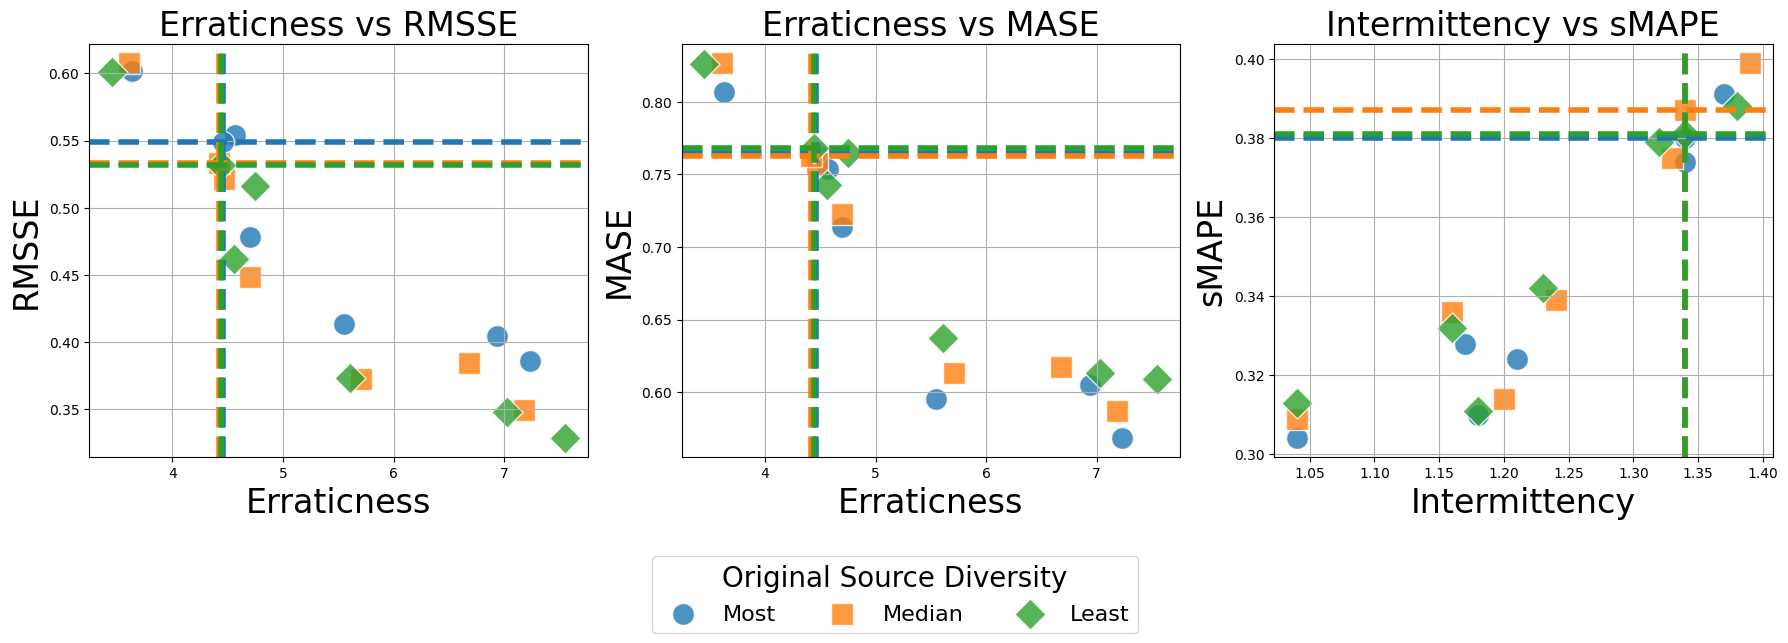

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

div_step_labels = {10: 'Most', 
                   5: 'Median', 
                   0: 'Least'}

color_map = {10: '#1f77b4',  # Blue
             5: '#ff7f0e',  # Orange
             0: '#2ca02c'}  # Green

marker_map = {10: 'o',  # Circle
              5: 's',  # Square
              0: 'D'}  # Diamond

legend_dict = {}

# Plot erraticness vs RMSSE
for div_step in all_metrics_df['div_step'].unique():
    subset = all_metrics_df[all_metrics_df['div_step'] == div_step]
    scatter = axes[0].scatter(subset['erraticness'], subset['RMSSE'], color=color_map[div_step], 
                               s=250, marker=marker_map[div_step], alpha=0.8,  
        edgecolor='white',  
        linewidth=1)  
    
    if div_step_labels[div_step] not in legend_dict:
        legend_dict[div_step_labels[div_step]] = scatter

# Add horizontal and vertical lines for source metrics
for div_step, source_metric in source_metrics.items():
    axes[0].axhline(y=source_metric["RMSSE"], color=color_map[div_step], linestyle='--', linewidth=4)  
    axes[0].axvline(x=source_metric["erraticness"], color=color_map[div_step], linestyle='--', linewidth=4)  

axes[0].set_xlabel('Erraticness', fontsize=24)
axes[0].set_ylabel('RMSSE', fontsize=24)
axes[0].grid()
axes[0].set_title('Erraticness vs RMSSE', fontsize=24)

# Plot erraticness vs MASE
for div_step in all_metrics_df['div_step'].unique():
    subset = all_metrics_df[all_metrics_df['div_step'] == div_step]
    scatter = axes[1].scatter(subset['erraticness'], subset['MASE'], color=color_map[div_step], 
                               s=250, marker=marker_map[div_step], alpha=0.8,  
        edgecolor='white',  
        linewidth=1)  
    
    if div_step_labels[div_step] not in legend_dict:
        legend_dict[div_step_labels[div_step]] = scatter

# Add horizontal and vertical lines for source metrics
for div_step, source_metric in source_metrics.items():
    axes[1].axhline(y=source_metric["MASE"], color=color_map[div_step], linestyle='--', linewidth=4)  
    axes[1].axvline(x=source_metric["erraticness"], color=color_map[div_step], linestyle='--', linewidth=4)  

axes[1].set_xlabel('Erraticness', fontsize=24)
axes[1].set_ylabel('MASE', fontsize=24)
axes[1].grid()
axes[1].set_title('Erraticness vs MASE', fontsize=24)

# Plot intermittency vs sMAPE
for div_step in all_metrics_df['div_step'].unique():
    subset = all_metrics_df[all_metrics_df['div_step'] == div_step]
    scatter = axes[2].scatter(subset['intermittency'], subset['sMAPE'], color=color_map[div_step], 
                               s=250, marker=marker_map[div_step], alpha=0.8,  
        edgecolor='white',  
        linewidth=1)  
    
    if div_step_labels[div_step] not in legend_dict:
        legend_dict[div_step_labels[div_step]] = scatter

# Add horizontal and vertical lines for source metrics 
for div_step, source_metric in source_metrics.items():
    axes[2].axhline(y=source_metric["sMAPE"], color=color_map[div_step], linestyle='--', linewidth=4)  
    axes[2].axvline(x=source_metric["intermittency"], color=color_map[div_step], linestyle='--', linewidth=4)  

axes[2].set_xlabel('Intermittency', fontsize=24)
axes[2].set_ylabel('sMAPE', fontsize=24)
axes[2].grid()
axes[2].set_title('Intermittency vs sMAPE', fontsize=24)

# Create a single legend with unique labels, and place it below the whole figure
handles = list(legend_dict.values())
labels = list(legend_dict.keys())
fig.legend(handles, labels, title='Original Source Diversity', loc='center', 
           fontsize=16, title_fontsize=20, borderaxespad=0.5, ncol=3, bbox_to_anchor=(0.5, -0.1)) 

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9]) 

plt.savefig(path_to_forecasts + f"evaluation/upper_bounds_{run}.pdf", bbox_inches='tight')
plt.savefig(path_to_forecasts + f"evaluation/upper_bounds_{run}.png", bbox_inches='tight')
plt.show()